# IMPLEMENTEZ UN MODELE DE SCORING

# Modélisations

### Contexte

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", proposant des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

### Missions
- **Mission 1: Construction d'un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.**
- **Mission 2: Construction d'un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.**
- **Mission 3: Mise en production du modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif appelant l’API pour les prédictions.**

In [1]:
# Import des librairies classiques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os

# Import des librairies pour le ML
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Import des librairies pour le scoring et le tracking
from sklearn.metrics import make_scorer
from sklearn import metrics
import mlflow
import mlflow.sklearn
import mlflow.catboost

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importances locales des variables
import shap

# Suppression des warnings pour SHAP :
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

C:\Users\colin\anaconda3\envs\projet7\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\colin\anaconda3\envs\projet7\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(al

C:\Users\colin\anaconda3\envs\projet7\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\colin\anaconda3\envs\projet7\lib\site-packages\shap\explainers\_partition.py:676: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def lower_credit(i, value, M, values, clustering):
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stabl

## LES FONCTIONS

### 1. Le score métier

**Concernant le score métier, il nous a été suggéré de considérer qu'un faux négatif (FN) est 10 fois supérieur au coût d’un faux positif (FP).**

In [2]:
def score_metier(y_true, y_pred):
    
    '''
    Fonction permettant de définir le score métier
    ----------------------------------------------
    - Retourne un score compris entre 0 et 1
    - Meilleur score = 0
    - Pire Score =1
    '''
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
    return (10*fn + fp)/ sum([tn, fp,10*fn, tp])

scorer_metier = make_scorer(score_metier,  greater_is_better=False)

### 2. Le seuil métier 

**L'établissement d'un seuil métier est courant dans les problèmes de classification, en particulier lorsque les coûts de faux positifs et de faux négatifs sont très différents. Par défaut, le seuil est de 0,5 pour une classification binaire : si la probabilité prédite d'appartenir à la classe positive est supérieure à 0,5, la prédiction est positive, sinon elle est négative.**

In [3]:
def business_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
    return (10*fn + fp) / sum([tn, fp, 10*fn, tp])

def seuil_metier(model, X_train, y_train, thresholds):
    '''Recherche du meilleur seuil via l'utilisation du score métier.'''
    
    y_probs = model.predict_proba(X_train)[:, 1]
    
    best_score = float('inf')
    best_threshold = 0
    scores = []
    
    for threshold in thresholds:
        y_pred = [1 if prob > threshold else 0 for prob in y_probs]
        
        # Utilisation de la fonction business_score
        score = business_score(y_train, y_pred)
        
        scores.append(score)
        
        if score < best_score:
            best_score = score
            best_threshold = threshold
            
    return best_threshold, best_score, scores

### 3. La matrice de confusion et la courbe ROC

In [4]:
def confusion_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    
    
    '''
    Fonction permettant la visualisation de la matrice de confusion et de la courbe ROC
    --------------------------------------------------------------------------------------
    Matrice de confusion pouvant être réalisée avec seuil de base (0,5) ou le seuil métier
    '''
    
    fig = plt.figure(figsize=(20,15))

    # Calcul de AUC-ROC
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Matrice de confusion
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.title('Matrice de confusion')

    # Courbe ROC
    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label=f'AUC = {roc_auc:.4f}')
    plt.title('Courbe ROC')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend()
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')  # ligne de référence pour un modèle aléatoire

    plt.tight_layout()
    plt.show()

### 4. La fonction pour le tracking via MLFLOW 

In [5]:
def business_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
    return (10 * fn + fp) / (tn + fp + 10 * fn + tp)

def seuil_metier(model, X, y, thresholds):
    y_probs = model.predict_proba(X)[:, 1]
    best_score = float('inf')
    best_threshold = 0
    scores = []
    
    for threshold in thresholds:
        y_pred = [1 if prob > threshold else 0 for prob in y_probs]
        score = business_score(y, y_pred)
        scores.append(score)
        
        if score < best_score:
            best_score = score
            best_threshold = threshold
            
    return best_threshold, best_score, scores

def mlflow_tracking(model, X_train, X_test, y_train, y_test, thresholds=np.linspace(0, 1, 100)):
    
    # Obtention du nombre de variables
    num_features = X_train.shape[1]
    
    # Nom du projet :
    mlflow.set_experiment('Projet7_Modelisations')

    with mlflow.start_run() as run:
        name = str(model).split('(')[0]
        mlflow.set_tag("mlflow.runName", datetime.datetime.today().strftime('%Y-%m-%d') + ' - ' + str(model).split('(')[0])
        
        # Obtention du nombre de features
        mlflow.log_param("Number of Features", num_features)
        
         # Entraînement du modèle
        start_time_fit = time.time()
        model.fit(X_train, y_train)
        end_time_fit = time.time()

         # Recherche du meilleur seuil sur l'ensemble d'entraînement
        best_threshold_train, best_score_train, _ = seuil_metier(model, X_train, y_train, thresholds)

         # Prédiction sur l'ensemble de test en utilisant le seuil optimal du train
        y_probs_test = model.predict_proba(X_test)[:, 1]
        y_pred_test_threshold = [1 if prob > best_threshold_train else 0 for prob in y_probs_test]
    
         # Prédiction sur l'ensemble d'entraînement en utilisant le seuil optimal du train
        y_probs_train = model.predict_proba(X_train)[:, 1]
        y_pred_train_threshold = [1 if prob > best_threshold_train else 0 for prob in y_probs_train]
        
        # Enregistrement des hyperparamètres
        mlflow.log_params(model.get_params())

        # Enregistrement des métriques
         # Calcul du temps d'entraînement
        training_time = end_time_fit - start_time_fit
        mlflow.log_metric("Training Time", training_time)
        
         # Enregistrement de l'accuracy pour les jeux d'entraînement et de test avec le seuil optimal
        acc_train = round(accuracy_score(y_train, y_pred_train_threshold) * 100, 4)
        mlflow.log_metric("Train Accuracy", acc_train)
        
        acc_test = round(accuracy_score(y_test, y_pred_test_threshold) * 100, 4)
        mlflow.log_metric("Test Accuracy", acc_test)
        
         # Enregistrement de l'AUC pour les jeux d'entraînement et de test 
        y_train_proba = model.predict_proba(X_train)[:, 1]
        auc_train = round(roc_auc_score(y_train, y_train_proba), 4)
        mlflow.log_metric("Train AUC", auc_train)
        
        y_test_proba = model.predict_proba(X_test)[:, 1]
        auc_test = round(roc_auc_score(y_test, y_test_proba), 4)
        mlflow.log_metric("Test AUC", auc_test)
        
         # Enregistrement du recall pour les jeux d'entraînement et de test avec le seuil optimal
        recall_train = round(recall_score(y_train, y_pred_train_threshold), 4)
        mlflow.log_metric("Train Recall", recall_train)
        
        recall_test = round(recall_score(y_test, y_pred_test_threshold, zero_division=0), 4)
        mlflow.log_metric("Test Recall", recall_test)
        
         # Enregistrement de la précision pour les jeux d'entraînement et de test avec le seuil optimal
        precision_train = round(precision_score(y_train, y_pred_train_threshold, zero_division=0), 4)
        mlflow.log_metric("Train Precision", precision_train)
        
        precision_test = round(precision_score(y_test, y_pred_test_threshold, zero_division=0), 4)
        mlflow.log_metric("Test Precision", precision_test)
        
         # Enregistrement du score f1 pour les jeux d'entraînement et de test
        f1_train = round(f1_score(y_train, y_pred_train_threshold), 4)
        mlflow.log_metric("Train f1", f1_train)
        
        f1_test = round(f1_score(y_test, y_pred_test_threshold, zero_division=0), 4)
        mlflow.log_metric("Test f1", f1_test)
        
         # Seuil métier et meilleur score métier
        mlflow.log_metric("Train Meilleur seuil", round(best_threshold_train, 4)) 
        mlflow.log_metric("Train Meilleur score metier", round(best_score_train, 4))
        best_score_test = business_score(y_test, y_pred_test_threshold)
        mlflow.log_metric("Test Meilleur score metier",  round(best_score_test, 4))
        
         # Sauvegarde du modèle
        mlflow.sklearn.log_model(model, "model")
        
        # Fin du RUN
        mlflow.end_run()
        
        # Création d'un DataFrame avec les métriques
        metrics_dict = {
            "Model": [str(model).split('(')[0]],
            "Training Time": round(training_time, 4),
            "Train Accuracy": round(acc_train, 4),
            "Test Accuracy": round(acc_test, 4),
            "Train AUC": round(auc_train, 4),
            "Test AUC": round(auc_test,4 ),
            "Train Recall": round(recall_train ,4),
            "Test Recall": round(recall_test, 4),
            "Train Precision": round(precision_train, 4),
            "Test Precision": round(precision_test, 4),
            "Train f1": round(f1_train, 4),
            "Test f1": round(f1_test, 4),
            "Best threshold": round(best_threshold_train, 4),
            "Train best score": round(best_score_train, 4),
            "Test best score": round(best_score_test, 4)
        }

        metrics_df = pd.DataFrame(metrics_dict).T

        return metrics_df

## MODELISATIONS DE BASE

**Dans ce projet, 5 modèles (dont 4 réels) seront testés dans un premier temps sans recherche d'hyperparamètre puis dans un deuxième temps avec optimisation des hyperparamètres.**
- **Le DummyClassifier comme baseline (demandé par OpenClassrooms)**
- **La régression logistisque**
- **Le CatBoostClassifier**
- **Le LGBMClassifier**
- **Le XGBClassifier**

**A Noter: Au départ, je souhaitais aussi tester le SVC, mais ce dernier a été éliminé. En effet, lors d'un premier essai, il s'est avéré qu'il était vraiment trop long à entraîner (modèle trop coûteux niveau temps).**

In [6]:
# Ouverture du jeu d'entraînement contenant les 30 premières variables
file_1 = pd.read_csv("trainset_rfe_30f.csv", sep=',')
pd.set_option("Display.max_rows", None)
pd.set_option("Display.max_columns", None)
file_1.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,YEARS_LAST_PHONE_CHANGE,YEARS_EMPLOYED,ANNUITY_INCOME_PERC,ANNUITY_RATE_PERC,CREDIT_INCOME_PERC,prev_AMT_ANNUITY_mean,prev_AMT_CREDIT_mean,prev_AMT_CREDIT_sum,prev_AMT_DOWN_PAYMENT_mean,prev_DAYS_DECISION_mean,prev_CNT_PAYMENT_mean,prev_AMT_PAYMENT_mean,prev_AMT_INSTALMENT_mean,prev_SK_DPD_count,home_DAYS_CREDIT_min,home_DAYS_CREDIT_ENDDATE_mean,home_AMT_CREDIT_SUM_sum,home_AMT_CREDIT_SUM_mean,home_AMT_CREDIT_SUM_DEBT_sum,prev_type_loans,prev_cash_loans_perc,total_accepted_loans
0,100002,1,202500.0,406597.5,24700.5,0.018801,0.083037,0.262949,0.139376,26.0,3.0,1.7,12.197778,6.074927,200.788889,9251.775,179055.00,179055.0,0.000000,606.000000,24.000000,11559.247105,11559.247105,19.0,103.0,115.625,865055.565,108131.945625,245775.0,1.0,0.0,9.0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,0.311267,0.622246,-2.000000,46.0,2.0,3.3,13.221667,2.759832,479.075000,56553.990,484191.00,1452573.0,2294.333333,1305.000000,10.000000,64754.586000,64754.586000,28.0,606.0,304.000,1017400.500,254350.125000,0.0,3.0,33.3,7.0
2,100004,0,67500.0,135000.0,6750.0,0.010032,-2.000000,0.555912,0.729567,52.0,2.0,0.6,10.000000,5.000000,200.000000,5357.250,20106.00,20106.0,4860.000000,815.000000,4.000000,7096.155000,7096.155000,4.0,408.0,0.000,189037.800,94518.900000,0.0,1.0,0.0,3.0
3,100006,0,135000.0,312682.5,29686.5,0.008019,-2.000000,0.650442,-2.000000,52.0,2.0,8.3,21.990000,9.494135,231.616667,12134.550,190960.50,1718644.5,7741.593333,272.444444,14.666667,62947.088438,62947.088438,21.0,0.0,0.000,0.000,0.000000,0.0,9.0,55.6,5.0
4,100007,0,121500.0,513000.0,21865.5,0.028663,-2.000000,0.322738,-2.000000,55.0,3.0,8.3,17.996296,4.262281,422.222222,12278.805,166638.75,999832.5,1128.916667,1222.833333,20.666667,12214.060227,12666.444545,66.0,1149.0,0.000,146250.000,146250.000000,0.0,6.0,66.7,7.0


In [7]:
# Copie du fichier
train_30 = file_1.copy()

In [8]:
X = train_30.drop(["SK_ID_CURR", "TARGET"], axis =1)
y = train_30["TARGET"]

# Séparation du jeu de données
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

# Ajustement uniquement sur les données d'entraînement (pour éviter la fuite de données)
scaler = MinMaxScaler()
scaler.fit(X_train)

# Transformation des jeux d'entraînement et de test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Vérification de la taille des différents dataframes
print(f'X_train : {X_train_scaled.shape}')
print(f'X_test : {X_test_scaled.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (246008, 30)
X_test : (61503, 30)
y_train : (246008,)
y_test : (61503,)


In [9]:
basic_dummy = DummyClassifier(random_state=42)
basic_lr= LogisticRegression(random_state=42, max_iter=500, n_jobs=-1, class_weight={0:1, 1:2}) # Obligation de fixer un max_iter
basic_cat = CatBoostClassifier(random_state=42, verbose=0, class_weights={0:1, 1:2})
basic_lgbmc = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:2})
basic_xgbc = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight= 2) # attribution d'un poids de 2 à la classe minoritaire
basic_models = []
basic_models.append(("DummyClassifier", basic_dummy))
basic_models.append(("LogisticRegression", basic_lr))
basic_models.append(("CatBoostClassifier", basic_cat))
basic_models.append(("LGBMClassifier", basic_lgbmc))
basic_models.append(("XGBClassifier", basic_xgbc))

In [10]:
# Création du dictionnaire pour le stockage des métriques de chaque modèle
metrics_dict = {}

for model_name, model in basic_models:
    basic_results = mlflow_tracking(model, X_train_scaled, X_test_scaled, y_train, y_test, thresholds=np.linspace(0, 1, 100))
    metrics_dict[model_name] = basic_results

# Création du dataframe global par concaténation des dataframes individuels en colonnes
basic_results = pd.concat(metrics_dict.values(), axis=1, keys=metrics_dict.keys())

# Elimination des 0 dans le nom des colonnes 
basic_results.columns = [col[0].replace('0', '') for col in basic_results.columns]

basic_results

Setuptools is replacing distutils.


,DummyClassifier,LogisticRegression,CatBoostClassifier,LGBMClassifier,XGBClassifier
Model,DummyClassifier,LogisticRegression,<catboost.core.CatBoostClassifier object at 0x...,LGBMClassifier,XGBClassifier
Training Time,0.024,10.0328,57.9457,3.4375,44.6267
Train Accuracy,91.9271,82.4433,84.1115,82.7786,83.5587
Test Accuracy,91.9272,82.5553,81.3456,82.1683,80.8676
Train AUC,0.5,0.6999,0.8652,0.8054,0.8676
Test AUC,0.5,0.7029,0.7677,0.7675,0.7616
Train Recall,0.0,0.3619,0.6885,0.5617,0.6985
Test Recall,0.0,0.3563,0.5223,0.5096,0.5156
Train Precision,0.0,0.1906,0.2936,0.2489,0.287
Test Precision,0.0,0.1902,0.2217,0.2287,0.2147


**Nous obtenons déjà des résultats intéressants sur les modèles de base, avec comme unique paramètre notre gestion du déséquilibre des classes.**

## OPTIMISATION DES MODELES

## 1. La régression logistique

In [11]:
'''# Paramètres à optimiser
lr_param_grid = {'C': [10, 20, 50, 100, 200], 'max_iter':[500, 1000, 2500, 5000]}

# Initialisation du modèle
lr_grid = LogisticRegression(random_state=42, class_weight={0:1, 1:2})

# Initialisation de la recherche sur grille avec validation croisée
lr_grid_search = GridSearchCV(lr_grid, lr_param_grid, cv=5, scoring=scorer_metier, n_jobs=-1)

# Entraînement
lr_grid_search.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres
best_param_lr = lr_grid_search.best_params_
best_param_lr'''

"# Paramètres à optimiser\nlr_param_grid = {'C': [10, 20, 50, 100, 200], 'max_iter':[500, 1000, 2500, 5000]}\n\n# Initialisation du modèle\nlr_grid = LogisticRegression(random_state=42, class_weight={0:1, 1:2})\n\n# Initialisation de la recherche sur grille avec validation croisée\nlr_grid_search = GridSearchCV(lr_grid, lr_param_grid, cv=5, scoring=scorer_metier, n_jobs=-1)\n\n# Entraînement\nlr_grid_search.fit(X_train_scaled, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_lr = lr_grid_search.best_params_\nbest_param_lr"

In [12]:
lr_1 = LogisticRegression(random_state=42, max_iter= 2500, class_weight={0:1, 1:2}, C=200, n_jobs=-1)

*A NOTER: Concernant le paramètre C, nous sommes à la limite supérieure.*

## 2. Le CatBoostClassifier

In [13]:
'''# Paramètres à optimiser
cat_param_grid = {'iterations': [50, 100, 200], 'depth': [2,4,8], 'learning_rate': [0.01, 0.05, 0.1]}

# Initialisation du modèle
cat_grid = CatBoostClassifier(random_state=42, verbose=0, class_weights= {0:1, 1:2})

# Initialisation de la recherche sur grille avec validation croisée
cat_grid_search = GridSearchCV(cat_grid, cat_param_grid, cv=5, scoring=scorer_metier, n_jobs=-1)

# Entraînement
cat_grid_search.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres
best_param_cat = cat_grid_search.best_params_
best_param_cat'''

"# Paramètres à optimiser\ncat_param_grid = {'iterations': [50, 100, 200], 'depth': [2,4,8], 'learning_rate': [0.01, 0.05, 0.1]}\n\n# Initialisation du modèle\ncat_grid = CatBoostClassifier(random_state=42, verbose=0, class_weights= {0:1, 1:2})\n\n# Initialisation de la recherche sur grille avec validation croisée\ncat_grid_search = GridSearchCV(cat_grid, cat_param_grid, cv=5, scoring=scorer_metier, n_jobs=-1)\n\n# Entraînement\ncat_grid_search.fit(X_train_scaled, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_cat = cat_grid_search.best_params_\nbest_param_cat"

Output: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}

In [14]:
cat_1 = CatBoostClassifier(random_state=42, verbose=0, class_weights= {0:1, 1:2} , max_depth=8, n_estimators=200, eta=0.1)

*A NOTER: Nous sommes à la limite supérieure pour tous les paramètres testés.*

## 3. Le LGBMClassifier

In [15]:
'''# Paramètres à optimiser
lgbm_param_grid = {'learning_rate': [0.001, 0.01, 0.05, 0.1], 'n_estimators': [25, 50, 100, 200], 'num_leaves': [4, 8, 16, 32]}

# Initialisation du modèle
lgbm_grid = LGBMClassifier(random_state=42, objective = 'binary', class_weight= {0:1, 1:2})

# Initialisation de la recherche sur grille avec validation croisée
lgbm_grid_search = GridSearchCV(lgbm_grid, lgbm_param_grid, cv=5, scoring=scorer_metier, n_jobs=-1)

# Entraînement
lgbm_grid_search.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres
best_param_lgbm = lgbm_grid_search.best_params_
best_param_lgbm'''

"# Paramètres à optimiser\nlgbm_param_grid = {'learning_rate': [0.001, 0.01, 0.05, 0.1], 'n_estimators': [25, 50, 100, 200], 'num_leaves': [4, 8, 16, 32]}\n\n# Initialisation du modèle\nlgbm_grid = LGBMClassifier(random_state=42, objective = 'binary', class_weight= {0:1, 1:2})\n\n# Initialisation de la recherche sur grille avec validation croisée\nlgbm_grid_search = GridSearchCV(lgbm_grid, lgbm_param_grid, cv=5, scoring=scorer_metier, n_jobs=-1)\n\n# Entraînement\nlgbm_grid_search.fit(X_train_scaled, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_lgbm = lgbm_grid_search.best_params_\nbest_param_lgbm"

output: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 16}

In [16]:
lgbmc_1= LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.1, objective='binary', num_leaves= 16, class_weight={0:1, 1:2}, n_jobs=-1)

*A NOTER: Comme pour le CatBoostClassifier, nous sommes à la limite supérieure pour la majorité des paramètres testés.*

## 4. Le XGBMClassifier

In [17]:
'''# Paramètres à optimiser
xgbc_param_grid = {'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [2, 4, 8], 'n_estimators': [50, 100, 200]}

# Initialisation du modèle
xgbc_grid = XGBClassifier(random_state=42, scale_pos_weight = 2)

# Initialisation de la recherche sur grille avec validation croisée
xgbc_grid_search = GridSearchCV(xgbc_grid, xgbc_param_grid, cv=5, scoring=scorer_metier, n_jobs=-1)

# Entraînement
xgbc_grid_search.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres
best_param_xgbc = xgbc_grid_search.best_params_
best_param_xgbc'''

"# Paramètres à optimiser\nxgbc_param_grid = {'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [2, 4, 8], 'n_estimators': [50, 100, 200]}\n\n# Initialisation du modèle\nxgbc_grid = XGBClassifier(random_state=42, scale_pos_weight = 2)\n\n# Initialisation de la recherche sur grille avec validation croisée\nxgbc_grid_search = GridSearchCV(xgbc_grid, xgbc_param_grid, cv=5, scoring=scorer_metier, n_jobs=-1)\n\n# Entraînement\nxgbc_grid_search.fit(X_train_scaled, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_xgbc = xgbc_grid_search.best_params_\nbest_param_xgbc"

output: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}

In [18]:
xgbc_1 = XGBClassifier(random_state=42, scale_pos_weight = 2, learning_rate = 0.1, max_depth = 8, n_estimators= 200, n_jobs=-1)

*A NOTER: Nous sommes à la limite supérieure pour tous les paramètres testés.*

In [19]:
# Modèles issus de la première optimisation
optimized_models_1 = []
optimized_models_1.append(("DummyClassifier", basic_dummy))
optimized_models_1.append(("LogisticRegression", lr_1))
optimized_models_1.append(("CatBoostClassifier", cat_1))
optimized_models_1.append(("LGBMClassifier", lgbmc_1))
optimized_models_1.append(("XGBClassifier", xgbc_1))

In [20]:
# Création du dictionnaire pour le stockage des métriques de chaque modèle
metrics_dict = {}

for model_name, model in optimized_models_1:
    optimized_results_1 = mlflow_tracking(model, X_train_scaled, X_test_scaled, y_train, y_test, thresholds=np.linspace(0, 1, 100))
    metrics_dict[model_name] = optimized_results_1

# Création du dataframe global par concaténation des dataframes individuels en colonnes
optimized_results_1 = pd.concat(metrics_dict.values(), axis=1, keys=metrics_dict.keys())

# Elimination des 0 dans le nom des colonnes 
optimized_results_1.columns = [col[0].replace('0', '') for col in optimized_results_1.columns]

optimized_results_1

,DummyClassifier,LogisticRegression,CatBoostClassifier,LGBMClassifier,XGBClassifier
Model,DummyClassifier,LogisticRegression,<catboost.core.CatBoostClassifier object at 0x...,LGBMClassifier,XGBClassifier
Training Time,0.024,49.2557,20.0874,4.571,126.8215
Train Accuracy,91.9271,82.2002,82.1933,80.5299,85.4415
Test Accuracy,91.9272,82.5196,81.1115,79.9294,81.131
Train AUC,0.5,0.7048,0.8172,0.805,0.9247
Test AUC,0.5,0.7073,0.7669,0.7679,0.7672
Train Recall,0.0,0.3745,0.6056,0.6066,0.8255
Test Recall,0.0,0.3738,0.5321,0.5519,0.5299
Train Precision,0.0,0.1917,0.2506,0.2311,0.3363
Test Precision,0.0,0.1954,0.2213,0.2131,0.2211


**Après ce premier dégrossissement, le modèle le plus intéressant en tous points mais surtout au niveau de NOTRE METRIQUE METIER serait le LGMBClassifier de base. Néanmoins, cette recherche d'optimisation a permis d'améliorer le CatBoostClassifier, le rendant très proche du LGMBClassifier de base. C'est pourquoi, un fine tuning sera réalisé sur ces 2 modèles. La régression logistique (modèle peu intéressant) et le XGBclassifier (modèle présentant non seulement plus d'overfitting mais aussi trop coûteux en terme de temps) sont éliminés pour la réalisation du fine tuning.**

## FINE-TUNING DES 2 MODELES

## 1. Le CatBoostClassifier

In [21]:
'''# Paramètres à optimiser
cat_param_grid_2 = {'iterations': [100, 200, 400, 1000], 'depth': [6, 8, 10], 'learning_rate': [0.005, 0.01, 0.05, 0.1]}

# Initialisation du modèle
cat_grid_2 = CatBoostClassifier(random_state=42, verbose=0, class_weights= {0:1, 1:2})

# Initialisation de la recherche sur grille avec validation croisée
cat_grid_search_2 = GridSearchCV(cat_grid_2, cat_param_grid_2, cv=5, scoring=scorer_metier, n_jobs=-1)

# Entraînement
cat_grid_search_2.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres
best_param_cat_2 = cat_grid_search_2.best_params_
best_param_cat_2'''

"# Paramètres à optimiser\ncat_param_grid_2 = {'iterations': [100, 200, 400, 1000], 'depth': [6, 8, 10], 'learning_rate': [0.005, 0.01, 0.05, 0.1]}\n\n# Initialisation du modèle\ncat_grid_2 = CatBoostClassifier(random_state=42, verbose=0, class_weights= {0:1, 1:2})\n\n# Initialisation de la recherche sur grille avec validation croisée\ncat_grid_search_2 = GridSearchCV(cat_grid_2, cat_param_grid_2, cv=5, scoring=scorer_metier, n_jobs=-1)\n\n# Entraînement\ncat_grid_search_2.fit(X_train_scaled, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_cat_2 = cat_grid_search_2.best_params_\nbest_param_cat_2"

In [22]:
cat_2 = CatBoostClassifier(random_state=42, verbose=0, class_weights= {0:1, 1:2} , max_depth=6, n_estimators=1000, eta=0.1)

## 2. Le LGBMClassifier

In [23]:
'''# Paramètres à optimiser
lgbm_param_grid_2 = {'learning_rate': [0.005, 0.01, 0.05, 0.1], 'n_estimators': [100, 200, 400, 1000], 'num_leaves': [4, 8, 16, 32]}

# Initialisation du modèle
lgbm_grid_2 = LGBMClassifier(random_state=42, objective = 'binary', class_weight= {0:1, 1:2})

# Initialisation de la recherche sur grille avec validation croisée
lgbm_grid_search_2 = GridSearchCV(lgbm_grid_2, lgbm_param_grid_2, cv=5, scoring=scorer_metier, n_jobs=-1)

# Entraînement
lgbm_grid_search_2.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres
best_param_lgbm_2 = lgbm_grid_search_2.best_params_
best_param_lgbm_2'''

"# Paramètres à optimiser\nlgbm_param_grid_2 = {'learning_rate': [0.005, 0.01, 0.05, 0.1], 'n_estimators': [100, 200, 400, 1000], 'num_leaves': [4, 8, 16, 32]}\n\n# Initialisation du modèle\nlgbm_grid_2 = LGBMClassifier(random_state=42, objective = 'binary', class_weight= {0:1, 1:2})\n\n# Initialisation de la recherche sur grille avec validation croisée\nlgbm_grid_search_2 = GridSearchCV(lgbm_grid_2, lgbm_param_grid_2, cv=5, scoring=scorer_metier, n_jobs=-1)\n\n# Entraînement\nlgbm_grid_search_2.fit(X_train_scaled, y_train)\n\n# Meilleurs hyperparamètres\nbest_param_lgbm_2 = lgbm_grid_search_2.best_params_\nbest_param_lgbm_2"

In [24]:
lgbmc_2 = LGBMClassifier(random_state=42, n_estimators=1000, learning_rate= 0.1 , objective='binary', num_leaves= 16, class_weight={0:1, 1:2}, n_jobs=-1)

In [25]:
# Modèles issus du fine tuning
optimized_models_2 = []
optimized_models_2.append(("CatBoostClassifier", cat_2))
optimized_models_2.append(("LGBMClassifier", lgbmc_2))

In [26]:
# Création du dictionnaire pour le stockage des métriques de chaque modèle
metrics_dict = {}

for model_name, model in optimized_models_2:
    optimized_results_2 = mlflow_tracking(model, X_train_scaled, X_test_scaled, y_train, y_test, thresholds=np.linspace(0, 1, 100))
    metrics_dict[model_name] = optimized_results_2

# Création du dataframe global par concaténation des dataframes individuels en colonnes
optimized_results_2 = pd.concat(metrics_dict.values(), axis=1, keys=metrics_dict.keys())

# Elimination des 0 dans le nom des colonnes 
optimized_results_2.columns = [col[0].replace('0', '') for col in optimized_results_2.columns]

optimized_results_2

,CatBoostClassifier,LGBMClassifier
Model,<catboost.core.CatBoostClassifier object at 0x...,LGBMClassifier
Training Time,69.3131,15.1767
Train Accuracy,82.755,83.8078
Test Accuracy,80.3262,80.4107
Train AUC,0.8607,0.8967
Test AUC,0.7688,0.7679
Train Recall,0.7024,0.7774
Test Recall,0.5432,0.539
Train Precision,0.2764,0.3036
Test Precision,0.2153,0.2152


**CONCLUSION DU FINE TUNING: Ce dernier a amoindri les performances du CatBoostClassifier et n'a pas permis d'obtenir de meilleurs résultats que le LGBMClassifier de base. Afin de mieux illustrer cela, un tableau récapitulatif sera réalisé pour ces 2 algorithmes, avec en plus l'entraînement des modèles sans le paramètre class_weight retenu dans le pécédent notebook.**

## TABLEAU RECAPITULATIF : CatBoostClassifier et LGBMClassifier

**Afin d'évaluer la différence entre le class_weights={0:1, 1:2} issu du précédent notebook et les auto_class_weight (CatBoostClassifier) / class_weight (LGBMClassifier) automatiques des 2 algorithmes, ces derniers seront ajoutés dans le tableau récapitulatif. De plus, n'étant pas certaine que le paramètre objective = "binary" soit le paramètre par défaut pour le LGBMClassifier, ce dernier modèle sera aussi testé.** 

In [27]:
# Liste des modèles
cat = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights="Balanced")
lgbmc = LGBMClassifier(random_state=42, class_weight="balanced")
lgbmc_binary = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:2}, objective='binary')
summary_results = []
summary_results.append(("CatBoost Base auto_class_weight", cat))
summary_results.append(("CatBoost Base avec class_weight retenu", basic_cat))
summary_results.append(("CatBoost Optimisation 1", cat_1))
summary_results.append(("CatBoost Optimisation 2", cat_2))
summary_results.append(("LGBMC Base class_weight", lgbmc))
summary_results.append(("LGBMC Base avec class_weight retenu", basic_lgbmc))
summary_results.append(("LGBMC avec Binary en objectif", lgbmc_binary))
summary_results.append(("LGBMC Optimisation 1", lgbmc_1))
summary_results.append(("LGBMC Optimisation 2", lgbmc_2))

In [28]:
# Création du dictionnaire pour le stockage des métriques de chaque modèle
metrics_dict = {}

for model_name, model in summary_results:
    summary_result = mlflow_tracking(model, X_train_scaled, X_test_scaled, y_train, y_test, thresholds=np.linspace(0, 1, 100))
    metrics_dict[model_name] = summary_result

# Création du dataframe global par concaténation des dataframes individuels en colonnes
summary_result = pd.concat(metrics_dict.values(), axis=1, keys=metrics_dict.keys())

# Elimination des 0 dans le nom des colonnes 
summary_result.columns = [col[0].replace('0', '') for col in summary_result.columns]

summary_result

,CatBoost Base auto_class_weight,CatBoost Base avec class_weight retenu,CatBoost Optimisation 1,CatBoost Optimisation 2,LGBMC Base class_weight,LGBMC Base avec class_weight retenu,LGBMC avec Binary en objectif,LGBMC Optimisation 1,LGBMC Optimisation 2
Model,<catboost.core.CatBoostClassifier object at 0x...,<catboost.core.CatBoostClassifier object at 0x...,<catboost.core.CatBoostClassifier object at 0x...,<catboost.core.CatBoostClassifier object at 0x...,LGBMClassifier,LGBMClassifier,LGBMClassifier,LGBMClassifier,LGBMClassifier
Training Time,68.2274,69.9305,19.7402,69.0898,3.2529,3.3183,3.1331,4.4778,14.4245
Train Accuracy,81.1421,84.1115,82.1933,82.755,80.801,82.7786,82.7786,80.5299,83.8078
Test Accuracy,78.4482,81.3456,81.1115,80.3262,80.4042,82.1683,82.1683,79.9294,80.4107
Train AUC,0.8857,0.8652,0.8172,0.8607,0.8032,0.8054,0.8054,0.805,0.8967
Test AUC,0.7641,0.7677,0.7669,0.7688,0.7674,0.7675,0.7675,0.7679,0.7679
Train Recall,0.7899,0.6885,0.6056,0.7024,0.5872,0.5617,0.5617,0.6066,0.7774
Test Recall,0.5813,0.5223,0.5321,0.5432,0.5482,0.5096,0.5096,0.5519,0.539
Train Precision,0.2709,0.2936,0.2506,0.2764,0.23,0.2489,0.2489,0.2311,0.3036
Test Precision,0.2052,0.2217,0.2213,0.2153,0.2172,0.2287,0.2287,0.2131,0.2152


**Optant davantage pour le LGBMClassifier avec comme seul paramètre le class_weight issu du notebook précédent, la matrice de confusion sera réalisée sur ce dernier mais aussi sur le CatBoostClassifier issu de la première optimisation.**

**A NOTER: Concernant le LGBMClassifier, l'ajout du paramètre objective = "binary" n'a eu aucun impact sur la performance du modèle, le rendant donc inutile.**

## CHOIX DU MODELE

## 1. Le LGBMClassifier

In [29]:
%%time
basic_lgbmc.fit(X_train_scaled, y_train)

CPU times: total: 20.8 s
Wall time: 3.24 s


LGBMClassifier(class_weight={0: 1, 1: 2}, random_state=42)

In [30]:
# Recherche du meilleur seuil métier
thresholds = [i/100 for i in range(0, 101)]
best_threshold_basic_lgbmc, best_score_threshold_basic_lgbmc, scores_basic_lgbmc = seuil_metier(basic_lgbmc, X_train_scaled, y_train, thresholds)
print(f"Best Threshold: {best_threshold_basic_lgbmc}, Best Score: {best_score_threshold_basic_lgbmc}")

Best Threshold: 0.22, Best Score: 0.3721552960965715


In [31]:
# Prédiction et probabilité pour la classe positive
y_probs_basic_lgbmc = basic_lgbmc.predict_proba(X_test_scaled)[:, 1]

# Application du seuil
y_pred_custom_threshold_basic_lgbmc = [1 if prob > best_threshold_basic_lgbmc else 0 for prob in y_probs_basic_lgbmc]

print(classification_report(y_test, y_pred_custom_threshold_basic_lgbmc))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     56538
           1       0.23      0.52      0.32      4965

    accuracy                           0.82     61503
   macro avg       0.59      0.68      0.61     61503
weighted avg       0.89      0.82      0.85     61503



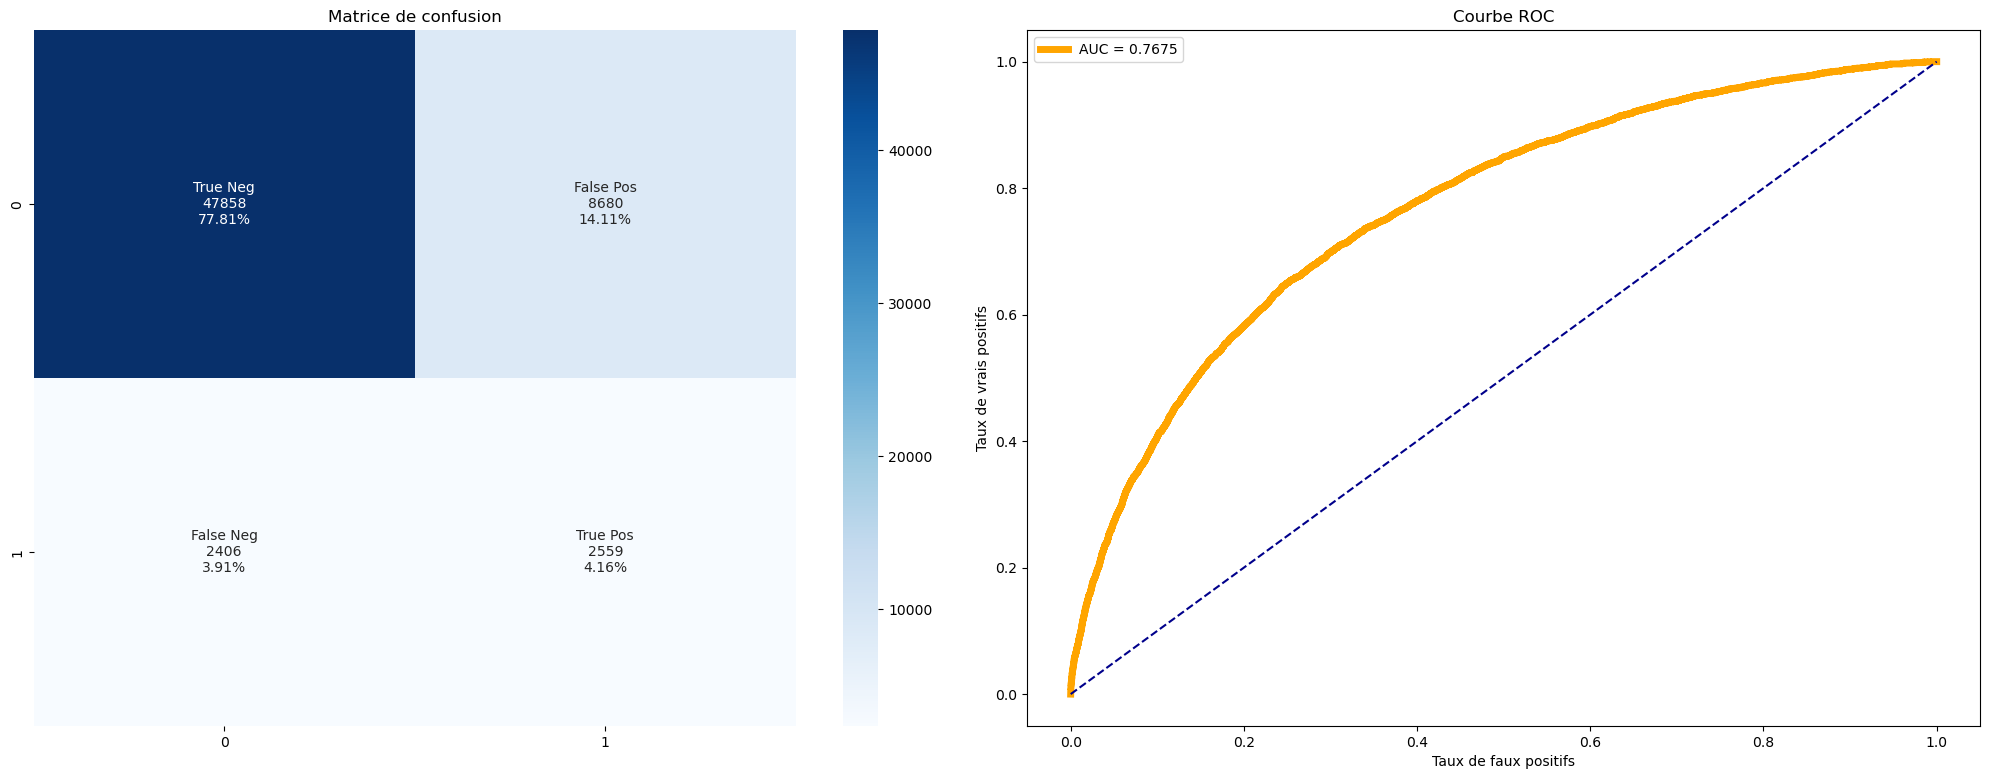

In [32]:
# Matrice de confusion et courbe ROC
confusion_matrix_roc_auc(basic_lgbmc, y_test, y_pred_custom_threshold_basic_lgbmc, basic_lgbmc.predict_proba(X_test_scaled)[:,1])

## 2. La CatBoostClassifier

In [33]:
%%time
cat_1.fit(X_train_scaled, y_train)

CPU times: total: 52.8 s
Wall time: 20.7 s


In [34]:
# Recherche du meilleur seuil métier
thresholds = [i/100 for i in range(0, 101)]
best_threshold_cat_1, best_score_threshold_cat_1, scores_cat_1 = seuil_metier(cat_1, X_train_scaled, y_train, thresholds)
print(f"Best Threshold: {best_threshold_cat_1}, Best Score: {best_score_threshold_cat_1}")

Best Threshold: 0.21, Best Score: 0.36105812796644005


In [35]:
# Prédiction et probabilité pour la classe positive
y_probs_cat_1 = cat_1.predict_proba(X_test_scaled)[:, 1]  

# Application du seuil
y_pred_custom_threshold_cat_1 = [1 if prob > best_threshold_cat_1 else 0 for prob in y_probs_cat_1]

print(classification_report(y_test, y_pred_custom_threshold_cat_1))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89     56538
           1       0.22      0.54      0.31      4965

    accuracy                           0.81     61503
   macro avg       0.59      0.68      0.60     61503
weighted avg       0.89      0.81      0.84     61503



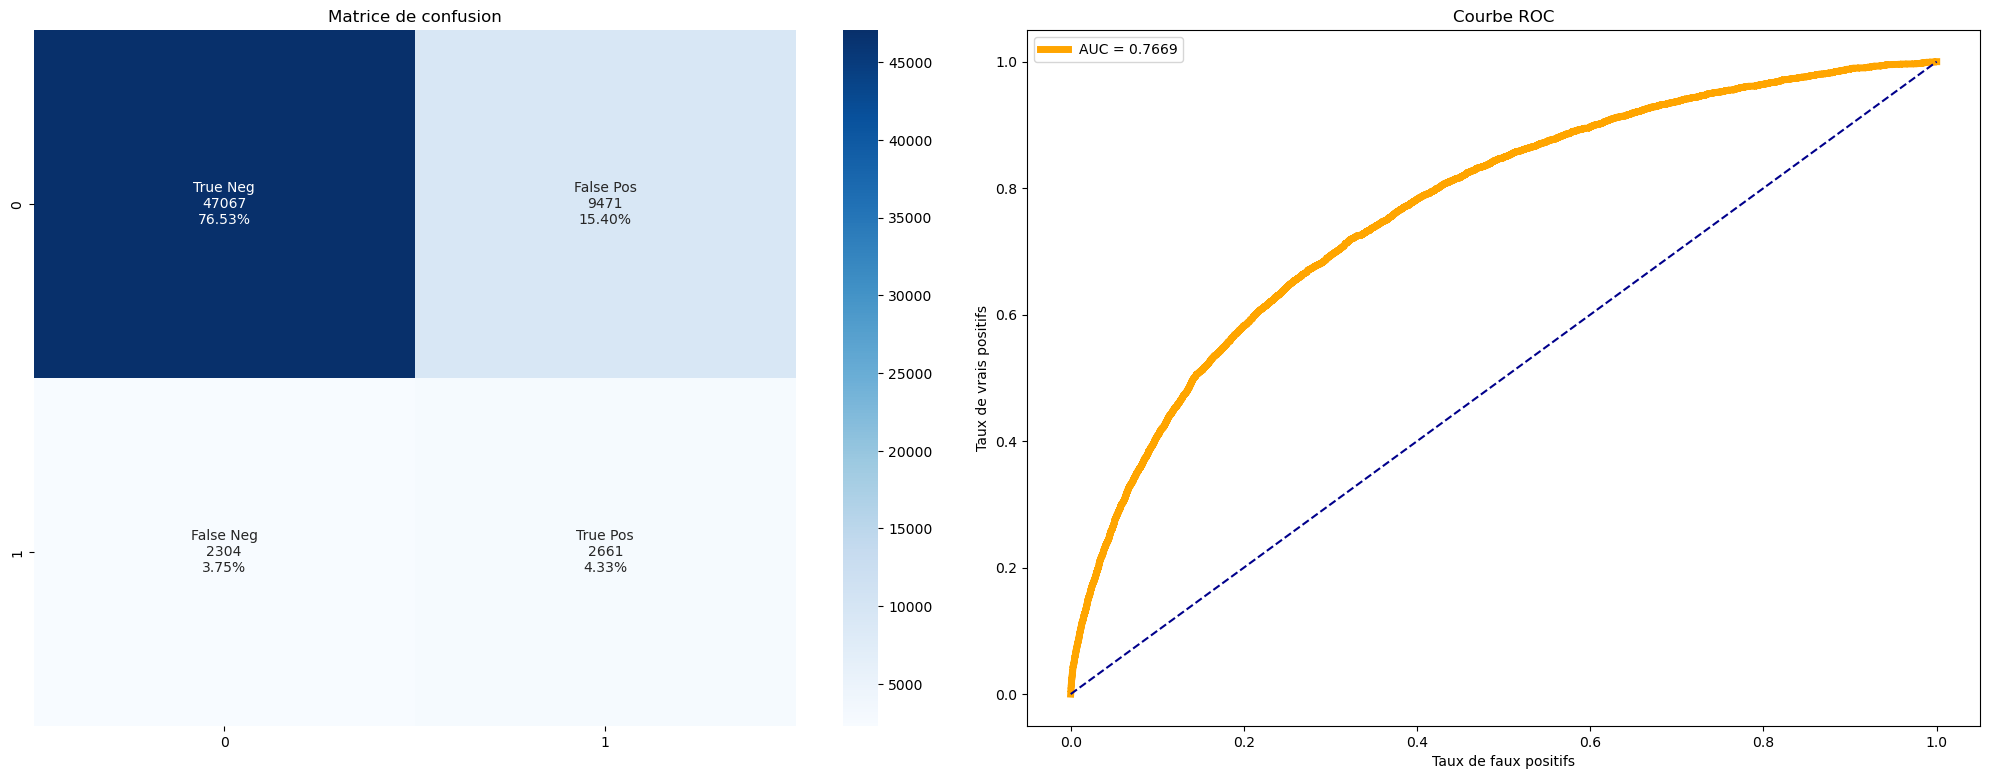

In [36]:
# Matrice de confusion et courbe ROC
confusion_matrix_roc_auc(cat_1, y_test, y_pred_custom_threshold_cat_1, cat_1.predict_proba(X_test_scaled)[:,1])

## 3. Choix et sauvegarde du modèle 

**Le modèle retenu sera le LGBM classifier avec comme seul paramètre le class_weight issu du précédent notebook ({0:1, 1:2}):**
- **Meilleur score métier sur le jeu de test que le CatBoostClassifier (mais un peu moins bon sur le jeu d'entraînement).**
- **Moindre (infime) sur-apprentissage (accuracy et AUC) que le CatBoostClassifier.**   

**Alors que Joblib est plus approprié aux modèles issus de scikit-learn, pickle est, quant à lui, utilisable pour tous les modèles de ML. Ainsi, la sauvegarde sera réalisée via pickle.**

In [37]:
# Sauvegarde du modèle
import pickle

pickle_file = "basic_lgbmc.pkl"

os.chdir("C:\\Users\\colin\\Documents\\Formation_Openclassrooms\\Projet7_ImplémentezUnModèleDeScoring")

pickle_file = "basic_lgbmc.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(basic_lgbmc, file)

In [38]:
# Vérification de la possibilité de chargement

with open(pickle_file, 'rb') as file:  
    basic_lgbmc = pickle.load(file)

basic_lgbmc

LGBMClassifier(class_weight={0: 1, 1: 2}, random_state=42)

## FEATURE IMPORTANCES ET VALEURS DE SHAPLEY

# 1. Les feature importances

**Les feature importances sont les principales variables importantes pour l'élaboration du modèle**

## 1.1. Les feature importances en valeur brute

In [39]:
%%time
params_base_basic_lgbmc = {}
basic_lgbmc = GridSearchCV(LGBMClassifier(random_state=42, class_weight={0:1, 1:2}), param_grid=params_base_basic_lgbmc, scoring= scorer_metier, cv=5, n_jobs=-1)
basic_lgbmc.fit(X_train_scaled, y_train)

CPU times: total: 20 s
Wall time: 11.2 s


GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight={0: 1, 1: 2},
                                      random_state=42),
             n_jobs=-1, param_grid={},
             scoring=make_scorer(score_metier, greater_is_better=False))

In [40]:
# Extraction du meilleur estimateur via GridSearchCV 
best_lgbmc = basic_lgbmc.best_estimator_

# Récupération des feature importances à partir du best_estimator
basic_lgbmc_feature_importances = best_lgbmc.feature_importances_

# Association de chaque importance à son nom de variables
feature_names = X.columns
basic_lgbmc_importances_series = pd.Series(basic_lgbmc_feature_importances, index=feature_names)

# Affichage des importances triées
print(basic_lgbmc_importances_series.sort_values(ascending=False))

ANNUITY_RATE_PERC                352
EXT_SOURCE_3                     205
EXT_SOURCE_1                     204
EXT_SOURCE_2                     191
AGE                              151
home_DAYS_CREDIT_min             124
YEARS_EMPLOYED                   121
AMT_ANNUITY                      117
prev_AMT_ANNUITY_mean            105
home_AMT_CREDIT_SUM_DEBT_sum     103
prev_CNT_PAYMENT_mean             97
AMT_CREDIT                        94
prev_AMT_DOWN_PAYMENT_mean        92
prev_AMT_PAYMENT_mean             88
prev_AMT_CREDIT_sum               86
home_AMT_CREDIT_SUM_sum           84
prev_SK_DPD_count                 79
prev_DAYS_DECISION_mean           77
home_AMT_CREDIT_SUM_mean          77
home_DAYS_CREDIT_ENDDATE_mean     71
REGION_POPULATION_RELATIVE        69
ANNUITY_INCOME_PERC               64
prev_AMT_CREDIT_mean              62
prev_AMT_INSTALMENT_mean          57
CREDIT_INCOME_PERC                52
AMT_INCOME_TOTAL                  48
total_accepted_loans              47
p

## 1.2. Conversion en pourcentage

In [41]:
# Conversion des importances en pourcentages
total_importance = basic_lgbmc_feature_importances.sum()
basic_lgbmc_feature_importances_percentage = 100 * (basic_lgbmc_feature_importances / total_importance)

# Association de chaque importance à son nom de variable
feature_names = X.columns
basic_lgbmc_importances_series = pd.Series(basic_lgbmc_feature_importances_percentage, index=feature_names)

# Arrondissement à deux chiffres après la virgule
basic_lgbmc_importances_series = basic_lgbmc_importances_series.round(2)

# Affichage des importances triées en pourcentage
print(basic_lgbmc_importances_series.sort_values(ascending=False))

ANNUITY_RATE_PERC                11.73
EXT_SOURCE_3                      6.83
EXT_SOURCE_1                      6.80
EXT_SOURCE_2                      6.37
AGE                               5.03
home_DAYS_CREDIT_min              4.13
YEARS_EMPLOYED                    4.03
AMT_ANNUITY                       3.90
prev_AMT_ANNUITY_mean             3.50
home_AMT_CREDIT_SUM_DEBT_sum      3.43
prev_CNT_PAYMENT_mean             3.23
AMT_CREDIT                        3.13
prev_AMT_DOWN_PAYMENT_mean        3.07
prev_AMT_PAYMENT_mean             2.93
prev_AMT_CREDIT_sum               2.87
home_AMT_CREDIT_SUM_sum           2.80
prev_SK_DPD_count                 2.63
prev_DAYS_DECISION_mean           2.57
home_AMT_CREDIT_SUM_mean          2.57
home_DAYS_CREDIT_ENDDATE_mean     2.37
REGION_POPULATION_RELATIVE        2.30
ANNUITY_INCOME_PERC               2.13
prev_AMT_CREDIT_mean              2.07
prev_AMT_INSTALMENT_mean          1.90
CREDIT_INCOME_PERC                1.73
AMT_INCOME_TOTAL         

## 1.3. Visualisation par histogramme (les 20 premières variables)

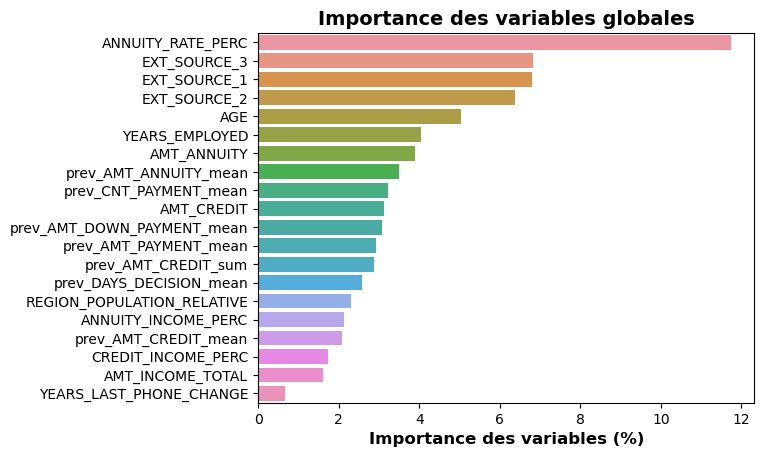

In [42]:
importances = basic_lgbmc_importances_series.head(20)
idx = X.columns

i, v =[],[]
for i_0, v_0 in sorted(zip(importances, idx), reverse =True):
    i.append(i_0)
    v.append(v_0)
    with sns.color_palette(palette="pastel"):
        plt.rcParams.update({"font.size":10})
        sns.barplot(x=i, y=v)
        plt.xlabel("Importance des variables (%)", fontname="sans-serif", fontsize=12, fontweight="bold")
        plt.xlim()
        plt.xticks()
        plt.title("Importance des variables globales", fontname="sans-serif", fontsize=14, fontweight="bold")

plt.show()

**Les 10 features les plus importantes pour l'entraînement de modèle sont respectivement:**
- **ANNUITY_RATE_PERC**
- **EXT_SOURCE_3**
- **EXT_SOURCE_1**
- **EXT_SOURCE_2**
- **AGE**
- **YEARS_EMPLOYED**
- **AMT_ANNUITY**
- **prev_AMT_ANNUITY_mean**
- **prev_CNT_PAYMENT_mean**
- **prev_AMT_PAYMENT_mean**

# 2. Les valeurs de Shapley

## 2.1. Les valeurs de shapley globales

**Elles permettent, pour une observation donnée, de quantifier l'impact de chaque feature de cette observation sur la prédiction qui lui est associée par le modèle.**

In [43]:
# Fit l'explainer
explainer = shap.TreeExplainer(best_lgbmc)

# Calcul des valeurs de Shapley 
shap_values = explainer.shap_values(X_train_scaled)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


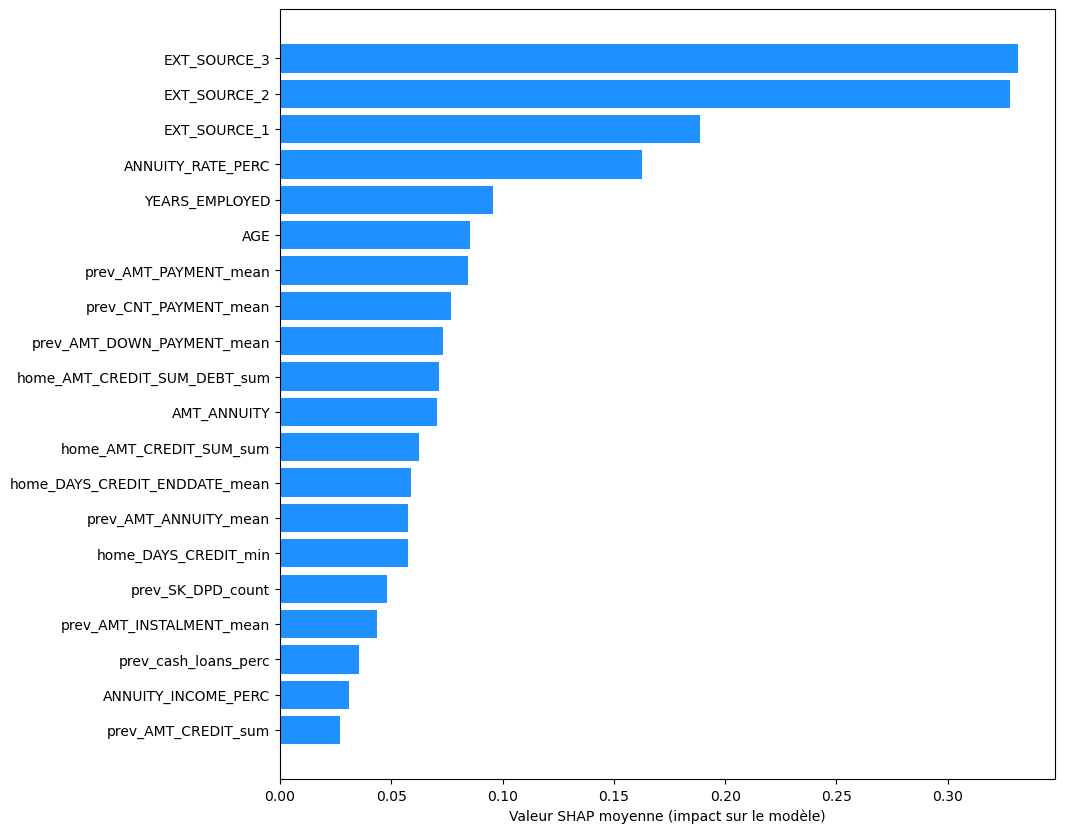

In [44]:
# Obtention des valeurs SHAP moyennes pour chaque feature
mean_shap_values = np.abs(shap_values[0]).mean(axis=0)

# Tri des valeurs
sorted_indices = np.argsort(mean_shap_values)[-20:]

# Création d'un bar plot avec les 20 premières features
plt.figure(figsize=(10, 10))
plt.barh(range(20), mean_shap_values[sorted_indices], color='dodgerblue')
plt.yticks(range(20), np.array(X.columns)[sorted_indices])
plt.xlabel("Valeur SHAP moyenne (impact sur le modèle)")
plt.show()

**Les 10 features contribuant en moyenne le plus à la prédiction du modèle sont respectivement:**
- **EXT_SOURCE_3**
- **EXT_SOURCE_2**
- **EXT_SOURCE_1**
- **ANNUITY_RATE_PERC**
- **YEARS_EMPLOYED**
- **AGE**
- **prev_AMT_PAYMENT_mean**
- **prev_CNT_PAYMENT_mean**
- **prev_AMT_DOWN_PAYMENT_mean**
- **home_AMT_CREDIT_SUM_DEBT_sum**

**De mon point de vue, il est crucial de comprendre non seulement dans quelle mesure et dans quelle direction les features influencent la prédiction. C'est pourquoi, les valeurs de Shapley seront réalisées et visualisées sur un client au hasard du jeu de test.**

## 2.2. Les valeurs locales de Shaphley  : Test sur un nouveau client

In [45]:
# Ouverture du jeu d'entraînement contenant les 30 premières variables
file_2 = pd.read_csv("testset_rfe_30f.csv", sep=',')
pd.set_option("Display.max_rows", None)
pd.set_option("Display.max_columns", None)
file_2.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,YEARS_LAST_PHONE_CHANGE,YEARS_EMPLOYED,ANNUITY_INCOME_PERC,ANNUITY_RATE_PERC,CREDIT_INCOME_PERC,prev_AMT_ANNUITY_mean,prev_AMT_CREDIT_mean,prev_AMT_CREDIT_sum,prev_AMT_DOWN_PAYMENT_mean,prev_DAYS_DECISION_mean,prev_CNT_PAYMENT_mean,prev_AMT_PAYMENT_mean,prev_AMT_INSTALMENT_mean,prev_SK_DPD_count,home_DAYS_CREDIT_min,home_DAYS_CREDIT_ENDDATE_mean,home_AMT_CREDIT_SUM_sum,home_AMT_CREDIT_SUM_mean,home_AMT_CREDIT_SUM_DEBT_sum,prev_type_loans,prev_cash_loans_perc,total_accepted_loans
0,100001,135000.0,568800.0,20560.5,0.018850,0.752614,0.789654,0.159520,53.0,5.0,6.4,15.230000,3.614715,421.333333,3951.00000,23787.000,23787.0,2520.00,1740.0,8.0,5885.132143,5885.132143,9.0,49.0,441.571429,1453365.00,207623.571429,596686.5,1.0,0.0,8.0
1,100005,99000.0,222768.0,17370.0,0.035792,0.564990,0.291656,0.432962,49.0,-0.0,12.2,17.545455,7.797350,225.018182,2406.60000,20076.750,40153.5,2232.00,536.0,5.0,6240.205000,6240.205000,11.0,62.0,482.000000,657126.00,219042.000000,568408.5,2.0,50.0,4.0
2,100013,202500.0,663264.0,69777.0,0.019101,-2.000000,0.699787,0.610991,55.0,2.0,12.2,34.457778,10.520245,327.537778,8608.64625,146134.125,584536.5,1687.00,837.5,12.5,9740.235774,10897.898516,36.0,1210.0,0.000000,2072280.06,518070.015000,-2.0,4.0,50.0,7.0
3,100028,315000.0,1575000.0,49018.5,0.026392,0.525734,0.509677,0.612704,38.0,5.0,5.1,15.561429,3.112286,500.000000,4854.95100,83057.400,415287.0,2249.60,1124.2,6.0,4356.731549,4979.282257,31.0,269.0,2716.000000,1520875.08,126739.590000,186300.5,5.0,20.0,15.0
4,100038,180000.0,625500.0,32067.0,0.010032,0.202145,0.425687,-2.000000,36.0,2.0,6.0,17.815000,5.126619,347.500000,5550.30000,46302.750,92605.5,4047.75,466.0,24.0,11100.337500,11100.337500,13.0,0.0,0.000000,0.00,0.000000,0.0,2.0,50.0,1.0


In [46]:
# Copie du fichier
test_shapley = file_2.copy()

In [47]:
# Elimination de la variable d'identification du client
test_shapley = test_shapley.drop("SK_ID_CURR", axis=1)
test_shapley.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,YEARS_LAST_PHONE_CHANGE,YEARS_EMPLOYED,ANNUITY_INCOME_PERC,ANNUITY_RATE_PERC,CREDIT_INCOME_PERC,prev_AMT_ANNUITY_mean,prev_AMT_CREDIT_mean,prev_AMT_CREDIT_sum,prev_AMT_DOWN_PAYMENT_mean,prev_DAYS_DECISION_mean,prev_CNT_PAYMENT_mean,prev_AMT_PAYMENT_mean,prev_AMT_INSTALMENT_mean,prev_SK_DPD_count,home_DAYS_CREDIT_min,home_DAYS_CREDIT_ENDDATE_mean,home_AMT_CREDIT_SUM_sum,home_AMT_CREDIT_SUM_mean,home_AMT_CREDIT_SUM_DEBT_sum,prev_type_loans,prev_cash_loans_perc,total_accepted_loans
0,135000.0,568800.0,20560.5,0.018850,0.752614,0.789654,0.159520,53.0,5.0,6.4,15.230000,3.614715,421.333333,3951.00000,23787.000,23787.0,2520.00,1740.0,8.0,5885.132143,5885.132143,9.0,49.0,441.571429,1453365.00,207623.571429,596686.5,1.0,0.0,8.0
1,99000.0,222768.0,17370.0,0.035792,0.564990,0.291656,0.432962,49.0,-0.0,12.2,17.545455,7.797350,225.018182,2406.60000,20076.750,40153.5,2232.00,536.0,5.0,6240.205000,6240.205000,11.0,62.0,482.000000,657126.00,219042.000000,568408.5,2.0,50.0,4.0
2,202500.0,663264.0,69777.0,0.019101,-2.000000,0.699787,0.610991,55.0,2.0,12.2,34.457778,10.520245,327.537778,8608.64625,146134.125,584536.5,1687.00,837.5,12.5,9740.235774,10897.898516,36.0,1210.0,0.000000,2072280.06,518070.015000,-2.0,4.0,50.0,7.0
3,315000.0,1575000.0,49018.5,0.026392,0.525734,0.509677,0.612704,38.0,5.0,5.1,15.561429,3.112286,500.000000,4854.95100,83057.400,415287.0,2249.60,1124.2,6.0,4356.731549,4979.282257,31.0,269.0,2716.000000,1520875.08,126739.590000,186300.5,5.0,20.0,15.0
4,180000.0,625500.0,32067.0,0.010032,0.202145,0.425687,-2.000000,36.0,2.0,6.0,17.815000,5.126619,347.500000,5550.30000,46302.750,92605.5,4047.75,466.0,24.0,11100.337500,11100.337500,13.0,0.0,0.000000,0.00,0.000000,0.0,2.0,50.0,1.0


In [48]:
# Vérification de la taille du dataframe
test_shapley.shape

(48744, 30)

In [49]:
# Chargement du modèle sélectionnné
selected_model = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:2})
selected_model.fit(X_train_scaled, y_train)

LGBMClassifier(class_weight={0: 1, 1: 2}, random_state=42)

In [50]:
# Sélection d'un client au hasard
test_new_client = test_shapley.sample(n=1, random_state=42)
test_new_client

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,YEARS_LAST_PHONE_CHANGE,YEARS_EMPLOYED,ANNUITY_INCOME_PERC,ANNUITY_RATE_PERC,CREDIT_INCOME_PERC,prev_AMT_ANNUITY_mean,prev_AMT_CREDIT_mean,prev_AMT_CREDIT_sum,prev_AMT_DOWN_PAYMENT_mean,prev_DAYS_DECISION_mean,prev_CNT_PAYMENT_mean,prev_AMT_PAYMENT_mean,prev_AMT_INSTALMENT_mean,prev_SK_DPD_count,home_DAYS_CREDIT_min,home_DAYS_CREDIT_ENDDATE_mean,home_AMT_CREDIT_SUM_sum,home_AMT_CREDIT_SUM_mean,home_AMT_CREDIT_SUM_DEBT_sum,prev_type_loans,prev_cash_loans_perc,total_accepted_loans
15071,450000.0,854896.5,36351.0,0.032561,0.637061,0.77189,-2.0,31.0,2.0,3.1,8.078,4.252094,189.977,16490.25,366043.5,366043.5,0.0,730.0,24.0,17200.328478,17200.328478,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [51]:
# Prédictions sur le nouveau client pris au hasard
predicted_test_new_client = selected_model.predict(test_new_client)
predicted_test_new_client

array([1], dtype=int64)

**A NOTER: Le client a déjà été prédit comme à risque par un simple predict, c'est-à-dire avec un seuil de 0.5 et non avec notre seuil métier de 0.2222 pour notre modèle. Si le client avait été prédit comme sans risque, un predict_proba aurait été réalisé.**
    
**IMPORTANT: Le Dashboard interactif sera réalisé sur le jeu de données de test en effectuant des predict_proba et en fixant le seuil d'octroi ou non du crédit à 0.2222.**     

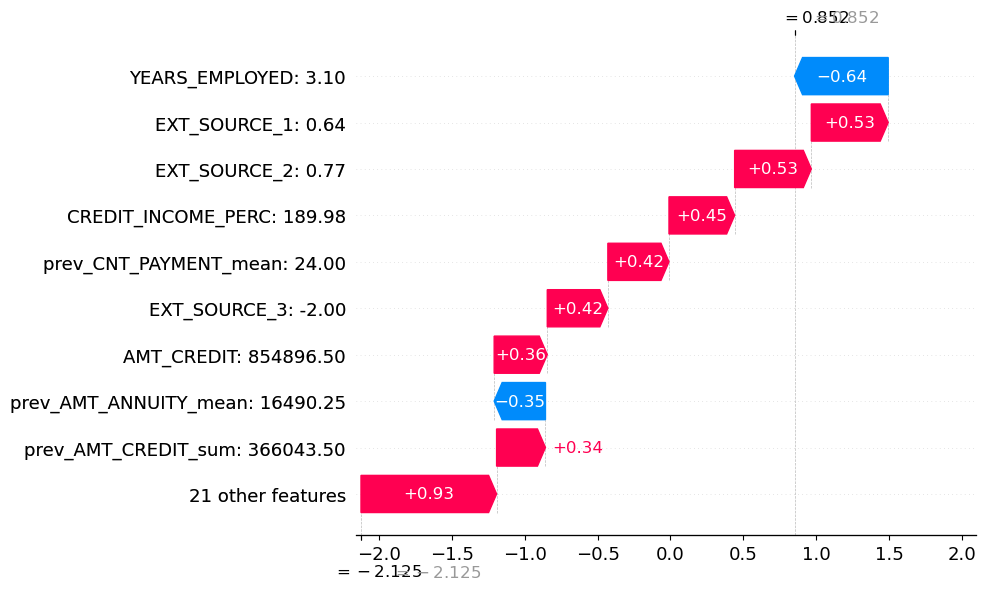

In [52]:
# Prédictions sur le nouveau client pris au hasard
predicted_test_new_client = selected_model.predict(test_new_client)


# Visualisation des valeurs SHAP
shap_values_test = explainer(test_new_client, check_additivity=False)

# Obtention des noms des variables et leurs valeurs pour le client
client_values = test_new_client.values[0]
column_names = test_new_client.columns

# Création d'une liste de chaînes de caractères contenant les noms de variables et leurs valeurs
variable_value_strings = [f"{col_name}: {value:.2f}" for col_name, value in zip(column_names, client_values)]

# Utilisation de shap.plots._waterfall.waterfall_legacy avec les noms de variables et leurs valeurs
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values_test[0].values[:,1],
                                      feature_names=variable_value_strings, max_display=10)


**Interprétation de ce graphique**
- **Les variables positives (rouge) sont celles qui ont joué en défaveur pour notre client à risque. Ainsi, plus la valeur est importante, plus la variable impacte sur la prédiction...**
- **A contrario, les variables négatives (bleu) sont celles qui lui ont été favorables.**

**A NOTER**: Ce notebook sera nommé 'Ple_Coline_6_notebook_modelisation_092023' dans les livrables et 'notebook_6_modelisation' sur GitHub.